In [2]:
#General import
from sklearn import metrics
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import List, Tuple
from IPython.display import display

#Qiskit import
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit.gate import Gate
algorithm_globals.random_seed = 13

#sklearn import
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.svm import SVC
from sklearn import datasets

In [6]:
class Individual():
    
    def __init__(
        self,
        numberOfGenes: int,
        numberOfFeatures: int,
        numberOfQubits: int,
        gates = [Gate]
    ) -> None:
    
        self._numberOfFeatures = numberOfFeatures
        self._numberOfGenes = numberOfGenes
        self._numberOfQubits = numberOfQubits
        self._genotype =  [[None, None, None, None] for _ in range(numberOfGenes)]
        self._gates = gates
        
        
    def generateFirstIndividual(
        self
    ) -> None:
        
        featurePositions = []
        
        while len(featurePositions) < self._numberOfFeatures:
            position = random.randint(0, self._numberOfGenes-1)
            if position not in featurePositions:
                featurePositions.append(position)
    
        feature = 0
        for gene in featurePositions:
            qubit = random.randint(0, self._numberOfQubits-1)
            self._genotype[gene][0] = RZGate
            self._genotype[gene][1] = qubit
            self._genotype[gene][2] = None
            self._genotype[gene][3] = feature
            feature = feature + 1    
            
        for gene in [i for i in range(self._numberOfGenes) if i not in featurePositions]:
            
            gate = random.choice(self._gates)
            
            self._genotype[gene][0] = gate
            
            if gate == RZGate:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                feature = random.randint(0, self._numberOfFeatures-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = feature
                
            elif gate == CXGate:
                
                control_qubit = random.randint(0, self._numberOfQubits-1)
                target_qubit = random.randint(0, self._numberOfQubits-1)
                while target_qubit == control_qubit:
                    target_qubit = random.randint(0, self._numberOfQubits-1)
                    
                self._genotype[gene][1] = target_qubit
                self._genotype[gene][2] = control_qubit
                self._genotype[gene][3] = None
                
            else:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = None


    @property
    def numberOfFeatures(self) -> int:
        return self._numberOfFeatures
    
    @property
    def numberOfQubits(self) -> int:
        return self._numberOfQubits
    
    @property
    def numberOfGenes(self) -> int:
        return self._numberOfGenes
    
    @property
    def gates(self) -> List[Gate]:
        return self._gates
    
    @property 
    def genotype(self) -> List[Tuple[Gate, int, int, int]]:
        return self._genotype
    
    @genotype.setter 
    def genotype(self, new_genotype: List[Tuple[Gate, int, int, int]]):

        if len(new_genotype)!=self._numberOfGenes:
                raise ValueError('Wrong genotype lenght')
        
        self._genotype = new_genotype
        

    def getFenotype(
        self
    ) -> QuantumCircuit:
        
        trainingParams = ParameterVector('x', self._numberOfFeatures)
        
        fenotype = QuantumCircuit(self._numberOfQubits)
        
        for gene in range(self._numberOfGenes):
                
                gate = self._genotype[gene][0]

                if gate == RZGate:
                    fenotype.append(gate(trainingParams[self._genotype[gene][3]]), [self._genotype[gene][1]])
                    
                elif gate == CXGate:
                    fenotype.append(gate(), [self._genotype[gene][2], self._genotype[gene][1]])
                    
                else:
                    fenotype.append(gate(), [self._genotype[gene][1]])    

                fenotype.barrier()    

        return fenotype


    def getFeatureMask(
        self
    ) -> np.ndarray:
        
        feature_mask = np.zeros(self._numberOfFeatures, dtype=bool)

        for gene in range(self._numberOfGenes):
            
            if self._genotype[gene][0] == RZGate:
                feature_mask[self._genotype[gene][3]] = 1

        return feature_mask
        

    def mutate(
        self, 
        probability: float = 0.1
    ) -> None:
        
        for gene in range(0, self._numberOfGenes):
            
            if random.random() < probability: 
                
                self._genotype[gene] = [None, None, None, None]
                
                gate = random.choice(self._gates)
            
                self._genotype[gene][0] = gate

                if gate == RZGate:
                    
                    qubit = random.randint(0, self._numberOfQubits-1)
                    feature = random.randint(0, self._numberOfFeatures-1)
                    self._genotype[gene][1] = qubit
                    self._genotype[gene][2] = None
                    self._genotype[gene][3] = feature
                    
                elif gate == CXGate:
                    
                    control_qubit = random.randint(0, self._numberOfQubits-1)
                    target_qubit = random.randint(0, self._numberOfQubits-1)
                    while target_qubit == control_qubit:
                        target_qubit = random.randint(0, self._numberOfQubits-1)
                        
                    self._genotype[gene][1] = target_qubit
                    self._genotype[gene][2] = control_qubit
                    self._genotype[gene][3] = None
                    
                else:
                    
                    qubit = random.randint(0, self._numberOfQubits-1)
                    self._genotype[gene][1] = qubit
                    self._genotype[gene][2] = None
                    self._genotype[gene][3] = None


def crossover(
    parent1: Individual,
    parent2: Individual,
    type: str
    ) -> Individual:

        if (
            parent1.numberOfFeatures != parent2.numberOfFeatures or
            parent1.numberOfGenes != parent2.numberOfGenes or
            parent1.numberOfQubits != parent2.numberOfQubits or
            parent1.gates != parent2.gates 
        ):      
            raise ValueError("Incompatabile parents") 

        if type not in ("Type 1", "Type 2"):
            raise ValueError("Non existent type") 

        child = Individual(
            numberOfFeatures=parent1.numberOfFeatures, 
            numberOfGenes=parent1.numberOfGenes, 
            numberOfQubits=parent1.numberOfQubits, 
            gates=parent1.gates
        )
      
        division_point = parent1.numberOfGenes // 2 #point where the circuit is cut

        if type=="Type 1":
            child.genotype = np.concatenate((parent1.genotype[:division_point], parent2.genotype[division_point:]))
        
        elif type=="Type 2":
            child.genotype = np.concatenate((parent2.genotype[:division_point], parent1.genotype[division_point:]))

        return child
        
def fit(
    individual: Individual, 
    X_train: np.ndarray,
    y_train: np.ndarray, 
    X_test: np.ndarray, 
    y_test: np.ndarray
) -> float:
        
    feature_map = individual.getFenotype()
    feature_mask = individual.getFeatureMask()        
    kernel = FidelityQuantumKernel(feature_map=feature_map)
    svc = SVC(kernel=kernel.evaluate)
    svc.fit(X_train[:, feature_mask], y_train)
    return svc.score(X_test[:, feature_mask], y_test)


def prob(x, exp=6):
    return [i**exp for i in x]

[[<class 'qiskit.circuit.library.standard_gates.rz.RZGate'>, 0, None, 0], [<class 'qiskit.circuit.library.standard_gates.sx.SXGate'>, 1, None, None], [<class 'qiskit.circuit.library.standard_gates.sx.SXGate'>, 0, None, None], [<class 'qiskit.circuit.library.standard_gates.rz.RZGate'>, 1, None, 0]]


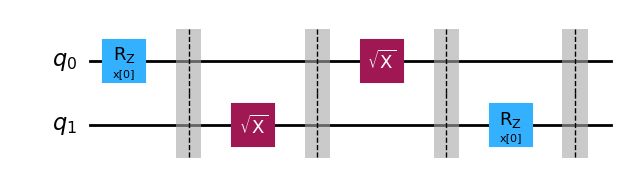

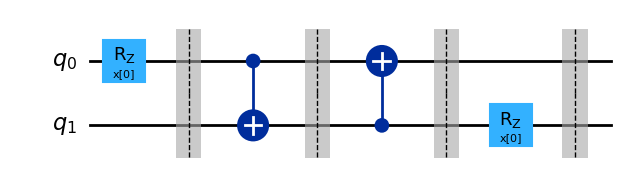

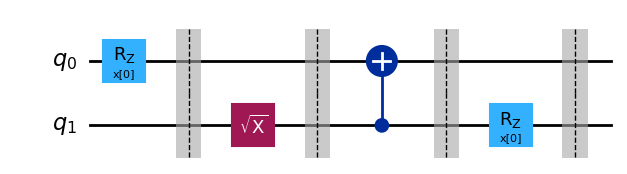

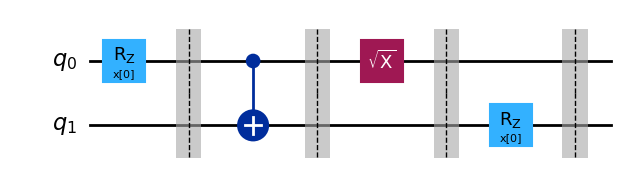

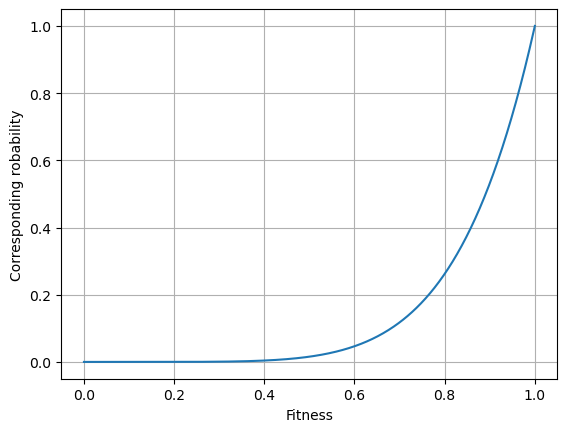

In [20]:
#Example 
gates = [XGate, SXGate, RZGate, CXGate]
firstParent = Individual(numberOfFeatures=1, numberOfGenes=4, numberOfQubits=2, gates=gates)
secondParent = Individual(numberOfFeatures=1, numberOfGenes=4, numberOfQubits=2, gates=gates)
firstParent.generateFirstIndividual()
secondParent.generateFirstIndividual()
firstChild = crossover(firstParent, secondParent, type="Type 1")
secondChild = crossover(firstParent, secondParent, type="Type 2")

print(firstParent.genotype)
display(firstParent.getFenotype().draw('mpl'))
display(secondParent.getFenotype().draw('mpl'))
display(firstChild.getFenotype().draw('mpl'))
display(secondChild.getFenotype().draw('mpl'))
#print(circuit_drawer(firstParent.getFenotype()))
#print(circuit_drawer(secondParent.getFenotype()))
#print(circuit_drawer(firstChild.getFenotype()))
#print(circuit_drawer(secondChild.getFenotype()))


#print sigmoid

x = np.linspace(0, 1, 500)
y=prob(x)
plt.plot(x, y)
plt.xlabel('Fitness')
plt.ylabel('Corresponding robability')
plt.grid(True)
plt.show()

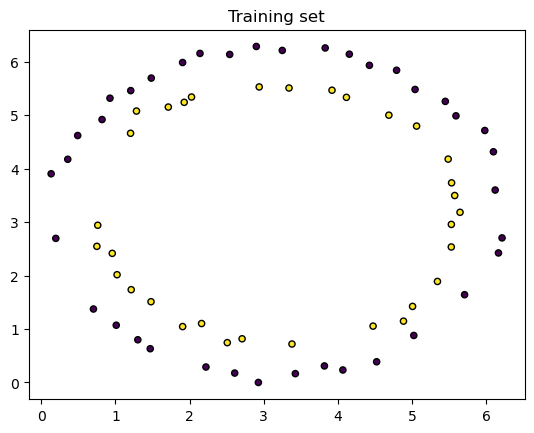

In [4]:
X, y = make_circles(n_samples=100, factor=0.8, noise=0.025, random_state=42)
#select which class and features to use
#class1 = 0
#class2 = 2
#feature1 = 0
#feature2 = 3
#
#iris = datasets.load_iris()
#
#X = iris.data[:, [feature1, feature2]]
#y = iris.target
#
#X = X[np.logical_or(y == class1, y == class2)]
#y = y[np.logical_or(y == class1, y == class2)]

X = MinMaxScaler(feature_range=(0, 2*np.pi)).fit_transform(X) #seems to have better results if compatible with the rotation encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13) 

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
plt.title('Training set')
plt.show()

In [22]:
maximumGenerations = 10
targetFitness = 0.99
numberOfGenes = 6
numberOfQubits = 2
gates = [XGate, SXGate, RZGate, CXGate]
k = 30

numberOfGenerations = 0

#Generate the first individual
bestIndividual = Individual(numberOfFeatures=X_train.shape[1], numberOfGenes=numberOfGenes, numberOfQubits=numberOfQubits, gates=gates)
bestIndividual.generateFirstIndividual()
feature_map = bestIndividual.getFenotype()
feature_mask = bestIndividual.getFeatureMask()
kernel = FidelityQuantumKernel(feature_map=feature_map)
svc = SVC(kernel=kernel.evaluate)
svc.fit(X_train[:, feature_mask], y_train)
bestFitness = svc.score(X_test[:, feature_mask], y_test)
bestSVC = svc

print(f'Generation number {numberOfGenerations}')
numberOfGenerations = numberOfGenerations + 1
print(f'Best fitness: {bestFitness}')
print(circuit_drawer(bestIndividual.getFenotype()))

while bestFitness < targetFitness and numberOfGenerations < maximumGenerations: 
    
    print(f'Generation number {numberOfGenerations}')
    numberOfGenerations = numberOfGenerations + 1

    currentGeneration = []
    
    #Generate k copies
    for i in range(k):
        currentGeneration.append(None)
        currentGeneration[i] = deepcopy(bestIndividual)

    #Mutates the k copies and evaluate the fitness
    for i in range(k):
        currentGeneration[i].mutate()
        feature_map = currentGeneration[i].getFenotype()
        feature_mask = currentGeneration[i].getFeatureMask()
        kernel = FidelityQuantumKernel(feature_map=feature_map)
        svc = SVC(kernel=kernel.evaluate)
        svc.fit(X_train[:, feature_mask], y_train)
        fitness = svc.score(X_test[:, feature_mask], y_test)
        print(f'Individual number {i+1}')
        print(f'Fitness: {fitness}')
        print(circuit_drawer(feature_map))
        
        if fitness > bestFitness:
            bestIndividual = currentGeneration[i]
            bestFitness = fitness
            bestSVC = svc
    
    #Print best circuit of the generation
    print('Best individual:')
    print(f'Best fitness: {bestFitness}')
    print('Best feature map:')
    print(circuit_drawer(bestIndividual.getFenotype()))
    print('------------------------------------')

KeyboardInterrupt: 

In [7]:
maximumGenerations = 25
targetFitness = 0.95
numberOfGenes = 10
numberOfQubits = 2
gates = [XGate, SXGate, RZGate, CXGate]
k = 10 #number of individuals surviving each generation
elite_dimension = k // 10 
numberOfGenerations = 0
bestFitness = 0

#Generate the first k individuals
currentGeneration = []
currentGenerationFitness = []
meanFitness = []

for i in range(k):
    print(f'Generating initial individual number {i+1} and evaluating fitness...')
    currentGeneration.append(Individual(numberOfFeatures=X_train.shape[1], numberOfGenes=numberOfGenes, numberOfQubits=numberOfQubits, gates=gates))
    currentGeneration[i].generateFirstIndividual()
    currentGenerationFitness.append(fit(currentGeneration[i], X_train, y_train, X_test, y_test))
    print(f'Inizial individual number {i+1}')
    print(f'Fitness: {currentGenerationFitness[i]}')
    #print(circuit_drawer(currentGeneration[i].getFenotype()))

meanFitness.append(np.mean(currentGenerationFitness))

badIndividual = currentGeneration[0] #I save one of the first for future comparison

numberOfGenerations = numberOfGenerations+1

while bestFitness < targetFitness and numberOfGenerations < maximumGenerations: 
    
    print(f'Generation number {numberOfGenerations}')
    print('')
    numberOfGenerations = numberOfGenerations+1

    childs=[]
    childsFitness=[]

    probabilities = prob(currentGenerationFitness)
    probabilities = probabilities / np.sum(probabilities)

    #pass the elite individual to the child generation as they are
    for _ in range(elite_dimension):
        elite_indices = np.argpartition(currentGenerationFitness, len(currentGenerationFitness)-1, axis=0)[(len(currentGenerationFitness)-elite_dimension):]
        childsFitness = np.take(currentGenerationFitness, elite_indices, axis=0).tolist()
        childs = np.take(currentGeneration, elite_indices, axis=0).tolist()

    #Create the childs
    for i in range(k-elite_dimension):

        print(f'Generating child {i+1}...')
        first_parent_index = np.random.choice(len(probabilities), p=probabilities)
        second_parent_index = np.random.choice(len(probabilities), p=probabilities)
        while first_parent_index==second_parent_index:
            second_parent_index = np.random.choice(len(probabilities), p=probabilities)

        first_parent = currentGeneration[first_parent_index]
        second_parent = currentGeneration[second_parent_index]
        child1 = crossover(first_parent, second_parent, type="Type 1")
        child2 = crossover(first_parent, second_parent, type="Type 2")
        child1.mutate()
        child2.mutate()
        child1_fitness = fit(child1, X_train, y_train, X_test, y_test)
        child2_fitness = fit(child2, X_train, y_train, X_test, y_test)

        if  child1_fitness > child2_fitness:
            childs.append(deepcopy(child1))
            childsFitness.append(child1_fitness)
        else:
            childs.append(deepcopy(child2))    
            childsFitness.append(child2_fitness)


    currentGeneration = deepcopy(childs)
    currentGenerationFitness = deepcopy(childsFitness)
    meanFitness.append(np.mean(currentGenerationFitness))

    #Print the generation
    print('')
    for i in range(k):
        print(f'Individual number {i+1}')
        print(f'Fitness: {currentGenerationFitness[i]}')
        #print(circuit_drawer(currentGeneration[i].getFenotype()))

    #Print best fitness of the generation
    print('')
    bestFitness = np.max(currentGenerationFitness)
    print(f'The best fitness of the generation is {bestFitness}')
    print('--------------------------------')

Generating initial individual number 1 and evaluating fitness...
Inizial individual number 1
Fitness: 0.3333333333333333
Generating initial individual number 2 and evaluating fitness...
Inizial individual number 2
Fitness: 0.3333333333333333
Generating initial individual number 3 and evaluating fitness...
Inizial individual number 3
Fitness: 0.4
Generating initial individual number 4 and evaluating fitness...
Inizial individual number 4
Fitness: 0.4
Generating initial individual number 5 and evaluating fitness...
Inizial individual number 5
Fitness: 0.3333333333333333
Generating initial individual number 6 and evaluating fitness...
Inizial individual number 6
Fitness: 0.4
Generating initial individual number 7 and evaluating fitness...
Inizial individual number 7
Fitness: 0.4
Generating initial individual number 8 and evaluating fitness...
Inizial individual number 8
Fitness: 0.43333333333333335
Generating initial individual number 9 and evaluating fitness...
Inizial individual number 

Fitness: 0.8666666666666667
     ┌──────────┐ ░              ░ ┌────┐ ░        ░              ░       ░ »
q_0: ┤ Rz(x[1]) ├─░──────────────░─┤ √X ├─░────────░──────────────░───■───░─»
     └──────────┘ ░ ┌──────────┐ ░ └────┘ ░ ┌────┐ ░ ┌──────────┐ ░ ┌─┴─┐ ░ »
q_1: ─────────────░─┤ Rz(x[0]) ├─░────────░─┤ √X ├─░─┤ Rz(x[0]) ├─░─┤ X ├─░─»
                  ░ └──────────┘ ░        ░ └────┘ ░ └──────────┘ ░ └───┘ ░ »
«            ░ ┌──────────┐ ░              ░ ┌──────────┐ ░ 
«q_0: ───────░─┤ Rz(x[0]) ├─░──────────────░─┤ Rz(x[1]) ├─░─
«     ┌────┐ ░ └──────────┘ ░ ┌──────────┐ ░ └──────────┘ ░ 
«q_1: ┤ √X ├─░──────────────░─┤ Rz(x[1]) ├─░──────────────░─
«     └────┘ ░              ░ └──────────┘ ░              ░ 
Accuracy:  0.8666666666666667


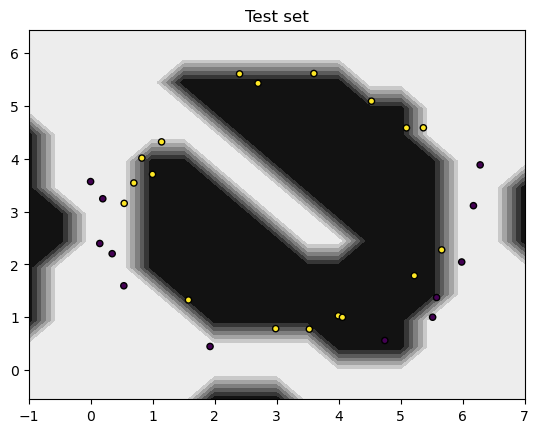

Fitness: 0.8666666666666667
     ┌────┐ ░ ┌───┐ ░        ░              ░        ░ ┌────┐ ░ ┌───┐ ░ ┌───┐»
q_0: ┤ √X ├─░─┤ X ├─░────────░──────────────░────────░─┤ √X ├─░─┤ X ├─░─┤ X ├»
     └────┘ ░ └───┘ ░ ┌────┐ ░ ┌──────────┐ ░ ┌────┐ ░ └────┘ ░ └─┬─┘ ░ └─┬─┘»
q_1: ───────░───────░─┤ √X ├─░─┤ Rz(x[1]) ├─░─┤ √X ├─░────────░───■───░───■──»
            ░       ░ └────┘ ░ └──────────┘ ░ └────┘ ░        ░       ░      »
«      ░       ░ ┌──────────┐ ░ 
«q_0: ─░───────░─┤ Rz(x[0]) ├─░─
«      ░ ┌───┐ ░ └──────────┘ ░ 
«q_1: ─░─┤ X ├─░──────────────░─
«      ░ └───┘ ░              ░ 
Accuracy:  0.6285714285714286


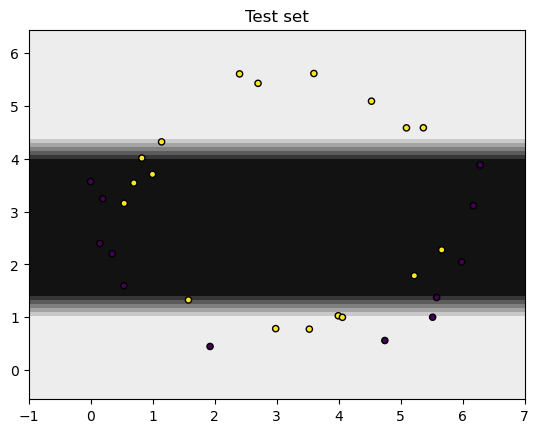

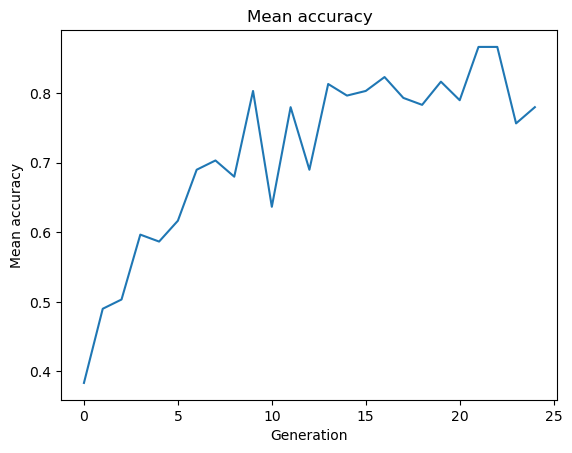

In [9]:
print(f'Fitness: {currentGenerationFitness[0]}')
feature_map = currentGeneration[0].getFenotype()
kernel = FidelityQuantumKernel(feature_map=feature_map)
print(circuit_drawer(feature_map))
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_test, y_test))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Test set')
plt.show()

print(f'Fitness: {currentGenerationFitness[0]}')
feature_map = badIndividual.getFenotype()
kernel = FidelityQuantumKernel(feature_map=feature_map)
print(circuit_drawer(feature_map))
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_train, y_train))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Test set')
plt.show()

plt.plot(meanFitness)
plt.title("Mean accuracy")
plt.xlabel("Generation")
plt.ylabel("Mean accuracy")
plt.show()

Fitness: 0.8666666666666667
     ┌──────────┐ ░              ░ ┌────┐ ░        ░              ░       ░ »
q_0: ┤ Rz(x[1]) ├─░──────────────░─┤ √X ├─░────────░──────────────░───■───░─»
     └──────────┘ ░ ┌──────────┐ ░ └────┘ ░ ┌────┐ ░ ┌──────────┐ ░ ┌─┴─┐ ░ »
q_1: ─────────────░─┤ Rz(x[0]) ├─░────────░─┤ √X ├─░─┤ Rz(x[0]) ├─░─┤ X ├─░─»
                  ░ └──────────┘ ░        ░ └────┘ ░ └──────────┘ ░ └───┘ ░ »
«            ░ ┌──────────┐ ░              ░ ┌──────────┐ ░ 
«q_0: ───────░─┤ Rz(x[0]) ├─░──────────────░─┤ Rz(x[1]) ├─░─
«     ┌────┐ ░ └──────────┘ ░ ┌──────────┐ ░ └──────────┘ ░ 
«q_1: ┤ √X ├─░──────────────░─┤ Rz(x[1]) ├─░──────────────░─
«     └────┘ ░              ░ └──────────┘ ░              ░ 
Accuracy:  0.94


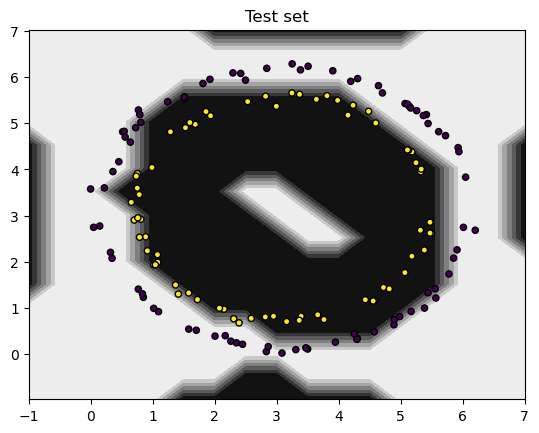

Fitness: 0.8666666666666667
     ┌────┐ ░ ┌───┐ ░        ░              ░        ░ ┌────┐ ░ ┌───┐ ░ ┌───┐»
q_0: ┤ √X ├─░─┤ X ├─░────────░──────────────░────────░─┤ √X ├─░─┤ X ├─░─┤ X ├»
     └────┘ ░ └───┘ ░ ┌────┐ ░ ┌──────────┐ ░ ┌────┐ ░ └────┘ ░ └─┬─┘ ░ └─┬─┘»
q_1: ───────░───────░─┤ √X ├─░─┤ Rz(x[1]) ├─░─┤ √X ├─░────────░───■───░───■──»
            ░       ░ └────┘ ░ └──────────┘ ░ └────┘ ░        ░       ░      »
«      ░       ░ ┌──────────┐ ░ 
«q_0: ─░───────░─┤ Rz(x[0]) ├─░─
«      ░ ┌───┐ ░ └──────────┘ ░ 
«q_1: ─░─┤ X ├─░──────────────░─
«      ░ └───┘ ░              ░ 
Accuracy:  0.5228571428571429


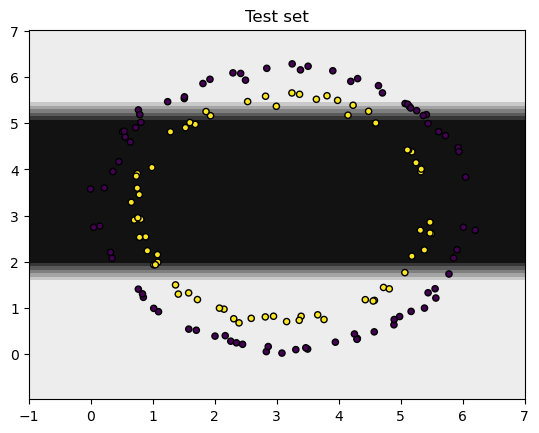

In [13]:
X, y = make_circles(n_samples=500, factor=0.8, noise=0.025, random_state=43) #changing the random state

X = MinMaxScaler(feature_range=(0, 2*np.pi)).fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13) 

print(f'Fitness: {currentGenerationFitness[0]}')
feature_map = currentGeneration[0].getFenotype()
kernel = FidelityQuantumKernel(feature_map=feature_map)
print(circuit_drawer(feature_map))
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_test, y_test))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Test set')
plt.show()

print(f'Fitness: {currentGenerationFitness[0]}')
feature_map = badIndividual.getFenotype()
kernel = FidelityQuantumKernel(feature_map=feature_map)
print(circuit_drawer(feature_map))
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_train, y_train))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Test set')
plt.show()

     ┌──────────┐ ░              ░ ┌────┐ ░        ░              ░       ░ »
q_0: ┤ Rz(x[1]) ├─░──────────────░─┤ √X ├─░────────░──────────────░───■───░─»
     └──────────┘ ░ ┌──────────┐ ░ └────┘ ░ ┌────┐ ░ ┌──────────┐ ░ ┌─┴─┐ ░ »
q_1: ─────────────░─┤ Rz(x[0]) ├─░────────░─┤ √X ├─░─┤ Rz(x[0]) ├─░─┤ X ├─░─»
                  ░ └──────────┘ ░        ░ └────┘ ░ └──────────┘ ░ └───┘ ░ »
«            ░ ┌──────────┐ ░              ░ ┌──────────┐ ░ 
«q_0: ───────░─┤ Rz(x[0]) ├─░──────────────░─┤ Rz(x[1]) ├─░─
«     ┌────┐ ░ └──────────┘ ░ ┌──────────┐ ░ └──────────┘ ░ 
«q_1: ┤ √X ├─░──────────────░─┤ Rz(x[1]) ├─░──────────────░─
«     └────┘ ░              ░ └──────────┘ ░              ░ 
Accuracy:  0.9333333333333333


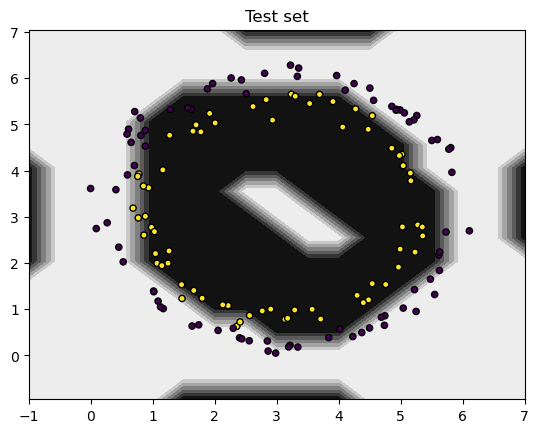

In [14]:
X, y = make_circles(n_samples=500, factor=0.8, noise=0.05, random_state=43) #changing the random state

X = MinMaxScaler(feature_range=(0, 2*np.pi)).fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13) 


feature_map = currentGeneration[0].getFenotype()
kernel = FidelityQuantumKernel(feature_map=feature_map)
print(circuit_drawer(feature_map))
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_test, y_test))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Test set')
plt.show()

     ┌──────────┐ ░              ░ ┌────┐ ░        ░              ░       ░ »
q_0: ┤ Rz(x[1]) ├─░──────────────░─┤ √X ├─░────────░──────────────░───■───░─»
     └──────────┘ ░ ┌──────────┐ ░ └────┘ ░ ┌────┐ ░ ┌──────────┐ ░ ┌─┴─┐ ░ »
q_1: ─────────────░─┤ Rz(x[0]) ├─░────────░─┤ √X ├─░─┤ Rz(x[0]) ├─░─┤ X ├─░─»
                  ░ └──────────┘ ░        ░ └────┘ ░ └──────────┘ ░ └───┘ ░ »
«            ░ ┌──────────┐ ░              ░ ┌──────────┐ ░ 
«q_0: ───────░─┤ Rz(x[0]) ├─░──────────────░─┤ Rz(x[1]) ├─░─
«     ┌────┐ ░ └──────────┘ ░ ┌──────────┐ ░ └──────────┘ ░ 
«q_1: ┤ √X ├─░──────────────░─┤ Rz(x[1]) ├─░──────────────░─
«     └────┘ ░              ░ └──────────┘ ░              ░ 
Accuracy:  0.9133333333333333


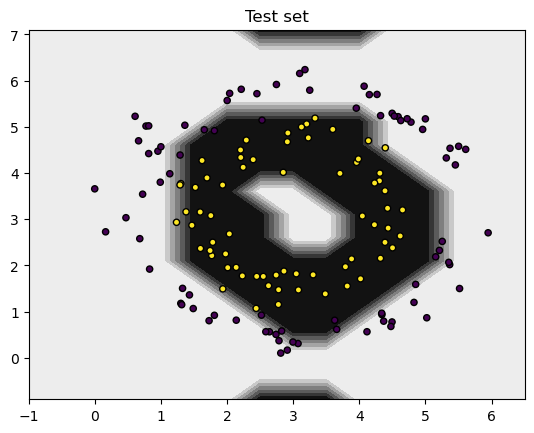

In [16]:
X, y = make_circles(n_samples=500, factor=0.6, noise=0.1, random_state=43) #changing the random state

X = MinMaxScaler(feature_range=(0, 2*np.pi)).fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13) 

feature_map = currentGeneration[0].getFenotype()
kernel = FidelityQuantumKernel(feature_map=feature_map)
print(circuit_drawer(feature_map))
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_test, y_test))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Test set')
plt.show()